In [82]:
from google.colab import drive

drive.mount("/content/gdrive")
!pwd  # show current path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content


In [83]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import seaborn as sns
from google.colab import files
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix, classification_report



#Nota
Ambas redes se entrenaron en 40 epochs

#Separación de los datos
Separamos los datos para Test, Train y valida, además hacemos uso de un generadpr de imágenes que se utilizan para preprocesar y aumentar los datos. **ImageDataGenerator** esta herramienta permite realizar transformaciones en las imágenes, como el escalado y la rotación. Lo configuro para realizar un escalado de 1/255 (normalización) y aplicar aumentos como el zoom, la inclinación (shear) y la rotación en las imágenes.

In [84]:


dataset_path = "/content/gdrive/MyDrive/IAcone/Bloque2/Modulo2/dataSets/cartasData/"

csv_file = pd.read_csv(dataset_path+"cards.csv")

bachSize=16
image_width, image_height = 200, 200
input_shape = (image_width, image_height, 3)

train_data_gen =ImageDataGenerator(rescale=1.0/255,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=10)

train_generator = train_data_gen.flow_from_directory(
    dataset_path + "train/",
    target_size=(image_width, image_height),
    batch_size=bachSize,
    class_mode='categorical'
)

test_data_gen = ImageDataGenerator(rescale=1.0/255,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=10)
test_generator = test_data_gen.flow_from_directory(
    dataset_path + "test/",

    target_size=(image_width, image_height),
    batch_size=bachSize,
    class_mode='categorical'
)

valid_data_gen = ImageDataGenerator(rescale=1.0/255,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=10)


valid_generator = valid_data_gen.flow_from_directory(
    dataset_path + "valid/",
    target_size=(image_width, image_height),

    batch_size=bachSize,
    class_mode='categorical'
)




Found 7683 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


#Transfer Learning

Se carga el modelo preentrenado VGG16 con los pesos de 'imagenet'. Este modelo servirá como base para mi modelo de clasificación. Se configura para excluir la capa de salida (include_top = False) y para que tenga la forma de entrada definida por input_shape (200, 200), que es el tamaño de cada imagen. Luego, se declara que los pesos de conv_base no serán reentrenados.

In [85]:
conv_base = VGG16(weights='imagenet',
								include_top = False,
								input_shape = input_shape)

#Check point
Establecemos la ruta donde guardaremos los pesos de nuestro entrenamiento, ya que por el tiempo de entrenamiento de corre riesgo de que el tiempo de ejecución sea interrunpido


save_weights_only: Solo guardaremos los pesos no la arquitectura.
save_freq: Se guardarán puntos de control cada 128 épocas durante el entrenamiento.
verbose: Es igual 1 para imprimir un mensaje cada que se guarde.

In [86]:
current_directory = "/content/gdrive/MyDrive/IAcone/Bloque2/Modulo2/entegaFrame2/checkPoint/"

checkpoint_path = current_directory + "checkPointcheckPoint128"
checkpoint_50 = ModelCheckpoint(filepath = checkpoint_path,
                                  save_weights_only = True,
                                  save_freq = 128,
                                  verbose = 1)

#Estableciendo el modelo
La red es un modelo Sequential con las siguientes capas: VGG16 pre-entrenada, Conv2D, Rescaling, otra Conv2D, Dropout, Flatten, Dense (128 neuronas), y Dense (53 neuronas). Tiene un total de 15,156,021 parámetros, de los cuales 441,333 son entrenables y 14,714,688 son no entrenables debido a la base pre-entrenada VGG16.

Se hace uso de el optimizador 'adam' y la función de pérdida 'categorical_crossentropy'. Se muestra un resumen del modelo y se verifica si existe un archivo de punto de control. Si existe, se cargan los pesos del modelo a partir de los ultimos pesos guardados.


In [87]:
model = Sequential()
model.add(conv_base)


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(Rescaling(1./255, input_shape=(200, 200, 3)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(53, activation='softmax'))


conv_base.trainable = False


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Train the model
if os.path.exists(checkpoint_path + '.index'):
    model.load_weights(checkpoint_path)
else:
    print(f"No se encontró un archivo de punto de control en {checkpoint_path}. Iniciando entrenamiento desde cero.")





Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 64)          294976    
                                                                 
 rescaling_8 (Rescaling)     (None, 4, 4, 64)          0         
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 128)         0         
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [88]:
history =model.fit(train_generator, epochs=1, validation_data=valid_generator, callbacks=[checkpoint_50])


127/481 [======>.......................] - ETA: 47:51 - loss: 0.5806 - accuracy: 0.8158
Epoch 1: saving model to /content/gdrive/MyDrive/IAcone/Bloque2/Modulo2/entegaFrame2/checkPoint/checkPointcheckPoint128
255/481 [==============>...............] - ETA: 31:08 - loss: 0.5795 - accuracy: 0.8146
Epoch 1: saving model to /content/gdrive/MyDrive/IAcone/Bloque2/Modulo2/entegaFrame2/checkPoint/checkPointcheckPoint128
383/481 [======================>.......] - ETA: 13:29 - loss: 0.5837 - accuracy: 0.8146
Epoch 1: saving model to /content/gdrive/MyDrive/IAcone/Bloque2/Modulo2/entegaFrame2/checkPoint/checkPointcheckPoint128
481/481 [==============================] - 4101s 9s/step - loss: 0.5865 - accuracy: 0.8139 - val_loss: 0.8019 - val_accuracy: 0.7811


# Guardamos el modelo.

In [89]:

model.save("cardsCNN.h5")
files.download("cardsCNN.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
loaded_model = load_model("/content/cardsCNN.h5")



#Evaluando el modelo
Evaluamos el modelo con el set de datos que previamente separamos

In [91]:

test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


17/17 [==============================] - 131s 8s/step - loss: 0.9336 - accuracy: 0.7736
Test Accuracy: 0.7735849022865295


La evaluación del modelo nos muestra un Accuracy: 0.7735849022865295 aun que bien esto ya nos da certeza de que nuesto modelono no esta adivinando, podemos mejorar nuesto modelo.

In [92]:
loaded_model

# Predicciones para el usuario
En esta sección, el usuario tiene la opción de cargar una imagen personal para poner a prueba el modelo.

In [108]:


#img_path = '/content/086.jpg'
img_path = '/content/061.jpg'
#img_path = '/content/156.jpg'

img = image.load_img(img_path, target_size=(200, 200))

img_array = image.img_to_array(img)


img_array = img_array / 255.0


img_array = np.expand_dims(img_array, axis=0)


In [109]:

prediction = loaded_model.predict(img_array)



1/1 [==============================] - 0s 130ms/step


In [110]:
predicted_class = np.argmax(prediction)
predicted_class
class_labels = train_generator.class_indices



llave_correspondiente = [llave for llave, valor in class_labels.items() if valor == predicted_class]

print(llave_correspondiente[0])


four of diamonds


In [96]:
class_labels = train_generator.class_indices
print(class_labels)

{'ace of clubs': 0, 'ace of diamonds': 1, 'ace of hearts': 2, 'ace of spades': 3, 'eight of clubs': 4, 'eight of diamonds': 5, 'eight of hearts': 6, 'eight of spades': 7, 'five of clubs': 8, 'five of diamonds': 9, 'five of hearts': 10, 'five of spades': 11, 'four of clubs': 12, 'four of diamonds': 13, 'four of hearts': 14, 'four of spades': 15, 'jack of clubs': 16, 'jack of diamonds': 17, 'jack of hearts': 18, 'jack of spades': 19, 'joker': 20, 'king of clubs': 21, 'king of diamonds': 22, 'king of hearts': 23, 'king of spades': 24, 'nine of clubs': 25, 'nine of diamonds': 26, 'nine of hearts': 27, 'nine of spades': 28, 'queen of clubs': 29, 'queen of diamonds': 30, 'queen of hearts': 31, 'queen of spades': 32, 'seven of clubs': 33, 'seven of diamonds': 34, 'seven of hearts': 35, 'seven of spades': 36, 'six of clubs': 37, 'six of diamonds': 38, 'six of hearts': 39, 'six of spades': 40, 'ten of clubs': 41, 'ten of diamonds': 42, 'ten of hearts': 43, 'ten of spades': 44, 'three of clubs':

12


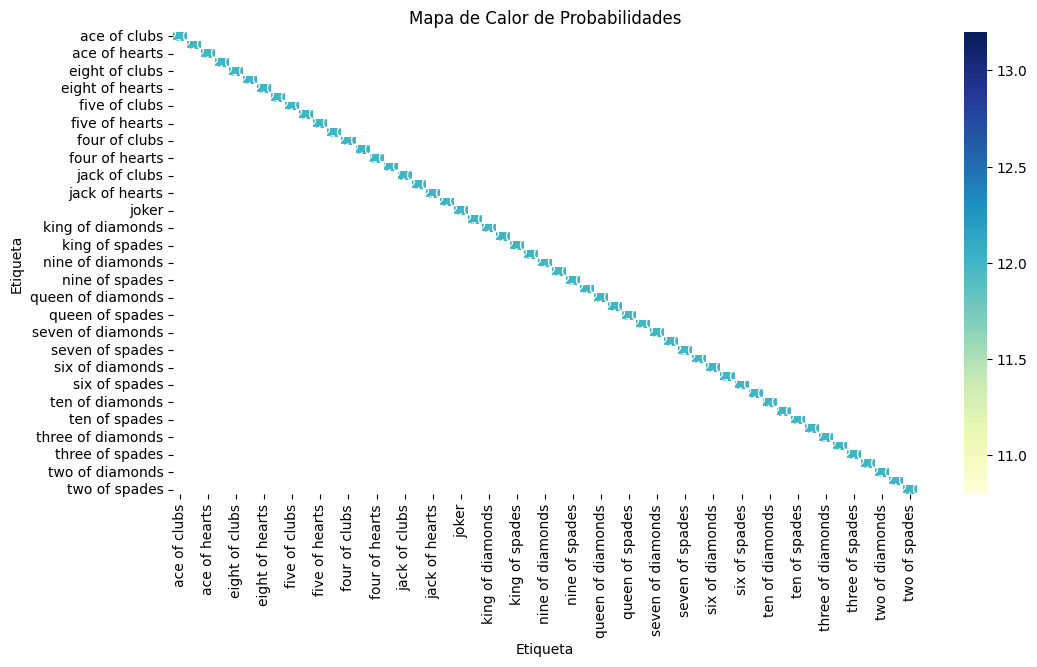

In [97]:

print(predicted_class)
# Obtén las probabilidades de predicción
probabilidades = predicted_class
# Convierte el diccionario class_labels en una lista de etiquetas ordenada
etiquetas = [etiqueta for etiqueta, _ in sorted(class_labels.items(), key=lambda x: x[1])]

# Crea un DataFrame con las probabilidades y etiquetas
data = {'Probabilidades': probabilidades, 'Etiqueta': etiquetas}
df = pd.DataFrame(data)

# Plotea un mapa de calor
plt.figure(figsize=(12, 6))
sns.heatmap(df.pivot_table(index='Etiqueta', columns='Etiqueta', values='Probabilidades', aggfunc='sum'), cmap='YlGnBu', annot=True, fmt='.2f')
plt.title(f"Mapa de Calor de Probabilidades")
plt.show()


#Red Neuronal Mejorada

In [98]:
conv_base = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= input_shape, pooling= 'max')
current_directory = "/content/gdrive/MyDrive/IAcone/Bloque2/Modulo2/entegaFrame2/checkPoint21/"

checkpoint_path = current_directory + "checkPoint64"
checkpoint_64 = ModelCheckpoint(filepath = checkpoint_path,
                                  save_weights_only = True,
                                  save_freq = 64,
                                  verbose = 1)

#Estableciendo el modelo
##Cambios para mejorar el modelo
### Red base
Para mejorar nuesto modelo se intentaron agragar más capas convolucionales, sin embargo eso alargo mucho el tiempo de entrenamiento, por lo que se opto por cambiar el modelo base.
Arquitectura Base:
La primer red usaba VGG16, la cambio por EfficientNetB3. Aprovechamos la transferencia de aprendizaje al utilizar pesos pre-entrenados de EfficientNetB3. Esto significa que los pesos de la arquitectura base (EfficientNetB3) se han entrenado en una gran cantidad de datos de imágenes (Imagenet).

EfficientNet es eficiente apesar de los recursos limitados, tambien al ser entrenada con una gran cantidad de imagenes se vuelve excelente para problemas de clasificación

###Optimizadores
Pasamos de usar adam a adamax

###Regularizadores
En la primer red solo apago un porcentaje de la red con Dropout, en el segundo modelo se usa L1 Y L2, los cuales ayudan a prevenir el sobreajuste.

In [99]:


# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= input_shape, pooling= 'max')

model = tf.keras.Sequential([
      # Asegúrate de usar 'padding' si es necesario
    base_model,
    tf.keras.layers.Reshape((1, 1, 1536)),  # Redefine las dimensiones
    tf.keras.layers.Dropout(rate=0.30, seed=42),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l=0.016), activity_regularizer=tf.keras.regularizers.l1(0.006),
                       bias_regularizer=tf.keras.regularizers.l1(0.006), activation='relu'),

    tf.keras.layers.Dense(53, activation='softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()
if os.path.exists(checkpoint_path + '.index'):
  model.load_weights(checkpoint_path)
else:
  print(f"No se encontró un archivo de punto de control en {checkpoint_path}. Iniciando entrenamiento desde cero.")





Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 1536)        0         
                                                                 
 dropout_5 (Dropout)         (None, 1, 1, 1536)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 1, 128)         1769600   
                                                                 
 batch_normalization_2 (Bat  (None, 1, 1, 128)         512       
 chNormalization)                                                
                                                                 
 flatten_5 (Flatten)         (None, 128)              

In [100]:

history=model.fit(train_generator, epochs=1, validation_data=valid_generator, callbacks=[checkpoint_64])




 63/481 [==>...........................] - ETA: 51:06 - loss: 0.6157 - accuracy: 0.9623
Epoch 1: saving model to /content/gdrive/MyDrive/IAcone/Bloque2/Modulo2/entegaFrame2/checkPoint21/checkPoint64
127/481 [======>.......................] - ETA: 43:23 - loss: 0.6096 - accuracy: 0.9582
Epoch 1: saving model to /content/gdrive/MyDrive/IAcone/Bloque2/Modulo2/entegaFrame2/checkPoint21/checkPoint64
191/481 [==========>...................] - ETA: 35:23 - loss: 0.6073 - accuracy: 0.9568
Epoch 1: saving model to /content/gdrive/MyDrive/IAcone/Bloque2/Modulo2/entegaFrame2/checkPoint21/checkPoint64
255/481 [==============>...............] - ETA: 27:44 - loss: 0.6160 - accuracy: 0.9534
Epoch 1: saving model to /content/gdrive/MyDrive/IAcone/Bloque2/Modulo2/entegaFrame2/checkPoint21/checkPoint64
319/481 [==================>...........] - ETA: 19:53 - loss: 0.6144 - accuracy: 0.9538
Epoch 1: saving model to /content/gdrive/MyDrive/IAcone/Bloque2/Modulo2/entegaFrame2/checkPoint21/checkPoint64
383/4

#Evaluamos el modelo
Tambien evaluamos con el set de datos test_generator

In [101]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

17/17 [==============================] - 32s 2s/step - loss: 1.3980 - accuracy: 0.7321
Test Accuracy: 0.7320754528045654


Obtenemos un accracy de 95% tambien reducimos la perdida.


In [102]:
model.save("cartasBetter.h5")
files.download("cartasBetter.h5")
loaded_model = load_model("/content/cartasBetter.h5")
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

17/17 [==============================] - 33s 2s/step - loss: 1.3820 - accuracy: 0.7547
Test Accuracy: 0.7547169923782349


In [103]:
img_path = '/content/156.jpg'
img = image.load_img(img_path, target_size=(200, 200))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)


In [104]:

prediction = loaded_model.predict(img_array)

predicted_class = np.argmax(prediction)
predicted_class
class_labels = train_generator.class_indices
llave_correspondiente = [llave for llave, valor in class_labels.items() if valor == predicted_class]


print(llave_correspondiente[0])


1/1 [==============================] - 4s 4s/step
four of clubs
